## Cell Dynamics Classification - using NaN for missing data and DTW metric

Group 10.  August 12, 2024

Contributor(s): Tim

This notebook performs **classification** using the **Dynamic Time Warping** Metric for the Cell Dynamics data provided by Nicolas Malagon. Missing data can be left as NaN or can be imputed. 

Dynamic Time Warping (DTW) is an algorithm that seasures similarity between two time series by aligning them in a nonlinear fashion to minimize the distance between corresponding points. Unlike the Euclidean metric, which measures vertical distance at the same time step, DTW can capturing similarities despite temporal distortions, variations in the number of time steps, or even missing data.
- Berndt, Donald J., and James Clifford. 'Using Dynamic Time Warping to Find Patterns in Time Series.' In KDD workshop, vol. 10, no. 16, pp. 359-370. 1994.  https://cdn.aaai.org/Workshops/1994/WS-94-03/WS94-03-031.pdf. 


#### Notes
- This notebook requires these preprocessed datasets with na values,
    - **df_wide_delta.csv**
    - **df_wide_log_area.csv**
    - **multi_level_combined_nonimputed_normalized.csv**
- Create the csvs by running **10_Preprocess_Nonimpute.ipynb**


## Problem Description

By employing unsupervised learning, we aim to generate clusters based on a specific cellular parameter, aiding our understanding of how tissues reduce their area. The parameters of interest are cell area and delta (the rate of change in cell size). This research can enhance our comprehension of the cell dynamics involved in the early stages of cancer.

The data contains 131 time series with between 39 and 49 time points each. The time series are extracted from three time lapse movies. They correspond to the development of 131 cells from three different fruit fly sex combs.  

In this notebook, we do not require that missing values be imputed. Missing values represent times at which the cells were unable to be measured accurately. Imputing may potentially bias the results. Instead, we will use the DTW metric, which can compare time series of different lengths.

We will use clustering techniques to investigate typical classes of cell development. This will help us to strategize different approaches toward the ultimate goal, which is to classify different spatio-temporal characteristics in the non-periodic oscillation of delta over time. 


#### Classification Steps
1. Load the data from csv
2. Prepare the data, converting the dfs to numpy arrays
3. K-Means with DTW
4. Hierarchical (Dendrogram) with DTW
5. GMM with DTW
6. DBSCAN with DTW
7. Overlap Matrix: shows the overlap between clusters found by different models


In [66]:
# Set the environment variable to avoid memory leak in KMeans
import os

# Set the environment variable 
os.environ['OMP_NUM_THREADS'] = '1'


In [68]:
# Install necessary libraries. 

# Uncomment next line if you don't have tslearn installed
# !pip install tslearn 


In [70]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings
import time
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from tslearn.metrics import cdist_dtw
from scipy.cluster.hierarchy import fcluster
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import cdist_dtw
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN


### 1. Load the data from csv
- Read wide format delta and log_area files
- Read multi-index file
- Convert to dataframes

#### CSV Files:
- **File Name**: `df_wide_delta.csv`
    - **Contents**: Contains the `df_wide_delta` DataFrame in CSV format, with each column representing the wide-format data for the normalized delta values. The rows correspond to the time points, and each column represents a unique cell identifier.

- **File Name**: `df_wide_log_area.csv`
    - **Contents**: Contains the `df_wide_log_area` DataFrame in CSV format, with each column representing the wide-format data for the normalized log-transformed area values. The rows correspond to the time points, and each column represents a unique cell identifier.

- **File Name**: `multi_level_combined_nonimputed_normalized.csv`
    - **Contents**: Contains the `multi_level_combined_nonimputed_normalized_df` DataFrame in CSV format, preserving the multi-level structure with 'Time (minutes)' as the index and 'Movie', 'Cell', and 'Trend' as levels. This file includes the normalized values of 'Delta' and 'Log_Area'.


#### Multi-Level DataFrame Structure

**Name**: `multi_level_combined_nonimputed_normalized_df`

**Columns**: MultiIndex with levels:

- **Index**: 'Time (minutes)'
    - The primary index representing the time in 20-minute increments for each measurement.
- **Level 1**: 'Movie'
    - The movie identifier (e.g., 'Mov. 1', 'Mov. 2').
- **Level 2**: 'Cell'
    - The cell identifier (e.g., 'Cell 1', 'Cell 2') for individual cells within each movie.
- **Level 3**: 'Trend'
    - The type of measurement, currently normalized 'Delta' (change in area) and log-transformed-then-normalized 'Area'.
 
**Index**: 'Time (minutes)'
- The primary index representing the time in 20-minute increments for each measurement.
  
**Description**: This DataFrame reorganizes the `df_transformed_normalized` into a wide level format with a MultiIndex on the columns. The MultiIndex consists of 'Movie', 'Cell', and 'Trend'. The 'Time (minutes)' serves as the index for the DataFrame. 


In [75]:
# Load the data

# Read df_wide_delta from CSV
df_wide_delta = pd.read_csv('df_wide_delta.csv')

# Read df_wide_log_area from CSV
df_wide_log_area = pd.read_csv('df_wide_log_area.csv')

# Read multi_level_combined_nonimputed_normalized_df from CSV
multi_level_combined_nonimputed_normalized_df = pd.read_csv('multi_level_combined_nonimputed_normalized.csv', header=[0, 1, 2], index_col=0)

# Display the head of each DataFrame to confirm successful loading
print("df_wide_delta:")
display(df_wide_delta.info())
display(df_wide_delta.head())

# print("df_wide_log_area:")
# display(df_wide_log_area.head())

# print("multi_level_combined_nonimputed_normalized_df:")
# display(multi_level_combined_nonimputed_normalized_df.head())


df_wide_delta:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Columns: 131 entries, Mov. 1 - Cell 1 to Mov. 3 - Cell 9
dtypes: float64(131)
memory usage: 49.3 KB


None

,Mov. 1 - Cell 1,Mov. 1 - Cell 10,Mov. 1 - Cell 10.1,Mov. 1 - Cell 11,Mov. 1 - Cell 11.1,Mov. 1 - Cell 12,Mov. 1 - Cell 12.1,Mov. 1 - Cell 13,Mov. 1 - Cell 13.1,Mov. 1 - Cell 14,...,Mov. 3 - Cell 53,Mov. 3 - Cell 54,Mov. 3 - Cell 55,Mov. 3 - Cell 56,Mov. 3 - Cell 57,Mov. 3 - Cell 58,Mov. 3 - Cell 6,Mov. 3 - Cell 7,Mov. 3 - Cell 8,Mov. 3 - Cell 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.593469,0.568741,0.591821,0.651166,0.558849,NaN,0.552255,0.642922,0.687435,0.547310
1,NaN,0.591864,0.603343,0.674849,0.603070,0.666380,0.602798,NaN,0.602526,NaN,...,0.603360,0.707216,0.466532,0.677544,0.634682,NaN,0.567093,0.539068,0.372565,0.565444
2,NaN,0.544448,0.650595,0.547833,0.656210,0.497030,0.661824,NaN,0.667438,NaN,...,0.471477,0.621494,0.585227,0.507746,0.539066,NaN,0.580280,0.662707,0.712163,0.608305
3,NaN,0.651136,0.527207,0.547833,0.521593,0.629121,0.515979,NaN,0.510365,NaN,...,0.626441,0.583577,0.603358,0.844042,0.603360,NaN,0.591819,0.555552,0.647869,0.623141
4,NaN,0.581705,0.642916,0.563076,0.648779,0.576625,0.654643,NaN,0.660506,NaN,...,0.519285,0.590171,0.639627,0.529177,0.389051,NaN,0.726999,0.535769,0.494557,0.535771


### 2. Prepare the data

- Calculate the number of time steps per movie.
- Set a boolean flag (`truncate_series`) to truncate all time series to the shortest length.
- Set a threshold (`nan_threshold`, a relative frequency) to filter out time series with excessive NaN values.
- Clean DataFrames and convert to numpy arrays (`log_area_series` and `delta_series`) for further analysis.
- Create identifier maps (`log_area_identifier_map` and `delta_identifier_map`) to track original cell identifiers.

In [78]:
# Initialize a dictionary to store the number of time steps for each movie
movie_time_steps = {}

# Loop over each movie in the DataFrame
for movie in multi_level_combined_nonimputed_normalized_df.columns.get_level_values('Movie').unique():
    # Extract the DataFrame for the current movie and the 'Delta' columns
    movie_df = multi_level_combined_nonimputed_normalized_df.xs(movie, level='Movie', axis=1)
    delta_df = movie_df.xs('Delta', level='Trend', axis=1)
    
    # Initialize a list to store the last valid time index for each column
    last_valid_indices = []

    # Loop over each column in the delta DataFrame
    for col in delta_df.columns:
        # Find the last non-NaN value in the column
        last_valid_index = delta_df[col].last_valid_index()
        if last_valid_index is not None:
            last_valid_indices.append(last_valid_index)
    
    # Determine the time steps by dividing the max time index by 20
    if last_valid_indices:
        movie_length = max(last_valid_indices) // 20 + 1  # Add 1 to convert from index to steps
        movie_time_steps[movie] = movie_length

# Determine the minimum number of time steps across all movies
min_time_steps = min(movie_time_steps.values())

# Print the lengths of each movie and the minimum time steps
print(f"Number of time steps for each movie: {movie_time_steps}")
print(f"The minimum number of time steps across all movies is: {min_time_steps}")


Number of time steps for each movie: {'Mov. 1': 39, 'Mov. 2': 41, 'Mov. 3': 48}
The minimum number of time steps across all movies is: 39


In [80]:
# Boolean flag to truncate all time series to the shortest length
truncate_series = False

# Set a threshold for the maximum percentage of NaNs allowed
nan_threshold = 0.25

# Make copies of the DataFrames to avoid changing the originals
df_wide_log_area_copy = df_wide_log_area.copy()
df_wide_delta_copy = df_wide_delta.copy()

# Convert NaN values to np.nan format if not already and ensure no deprecated warning
df_wide_log_area_copy = df_wide_log_area_copy.apply(lambda x: np.where(pd.isna(x), np.nan, x))
df_wide_delta_copy = df_wide_delta_copy.apply(lambda x: np.where(pd.isna(x), np.nan, x))

# Truncate all series to the shortest length if truncate_series is True
if truncate_series:
    df_wide_log_area_copy = df_wide_log_area_copy.iloc[:min_time_steps, :]
    df_wide_delta_copy = df_wide_delta_copy.iloc[:min_time_steps, :]
    print(f"Note: All series have been truncated to {min_time_steps} time steps")

# Identify and filter out time series with more than the allowed percentage of NaNs
valid_log_area_indices = (df_wide_log_area_copy.isna().mean(axis=0) <= nan_threshold)
valid_delta_indices = (df_wide_delta_copy.isna().mean(axis=0) <= nan_threshold)

print(f"Columns with NaNs above threshold in log_area_series: {(~valid_log_area_indices).sum()}")
print(f"Columns with NaNs above threshold in delta_series: {(~valid_delta_indices).sum()}")

df_wide_log_area_copy = df_wide_log_area_copy.loc[:, valid_log_area_indices]
df_wide_delta_copy = df_wide_delta_copy.loc[:, valid_delta_indices]

# Re-create the identifier map after filtering
log_area_identifier_map = {cell: idx for idx, cell in enumerate(df_wide_log_area_copy.columns)}
delta_identifier_map = {cell: idx for idx, cell in enumerate(df_wide_delta_copy.columns)}

# Convert DataFrames to numpy arrays
log_area_series = df_wide_log_area_copy.T.to_numpy()
delta_series = df_wide_delta_copy.T.to_numpy()


Columns with NaNs above threshold in log_area_series: 24
Columns with NaNs above threshold in delta_series: 23


In [82]:
# Write delta_series to a CSV file
np.savetxt('delta_series.csv', delta_series, delimiter=',', fmt='%f')

# Write log_area_series to a CSV file
np.savetxt('log_area_series.csv', log_area_series, delimiter=',', fmt='%f')

print("NumPy arrays have been written to CSV files.")


NumPy arrays have been written to CSV files.


### 3. Time Series K-Means Clustering with the Dynamic Time Warping (DTW) Metric
- Strengths: Simple and efficient for clustering when the number of clusters is known.
- Best For: Well-defined, spherical clusters. Less effective for non-stationary or oscillating data.
- https://scikit-learn.org/stable/modules/clustering.html#k-means 

In [85]:
# start_time = time.time()  # Start timing

# # Function to report clustering results
# def report_clustering_results(series, series_name):
#     print(f"Clustering results for {series_name}:")
#     for k in range(2, 11):
#         model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=123)
#         cluster_labels = model.fit_predict(series)
#         num_clusters = len(set(cluster_labels))
#         print(f"Number of clusters for k={k}: {num_clusters}")

# # Clustering on delta_series
# report_clustering_results(delta_series, "delta_series")

# # Clustering on log_area_series
# report_clustering_results(log_area_series, "log_area_series")

# end_time = time.time()  # End timing
# elapsed_time = end_time - start_time  # Calculate elapsed time
# print(f"Time taken: {elapsed_time:.4f} seconds")

### Summary of Clustering Results

We performed Time Series K-Means clustering using the Dynamic Time Warping (DTW) metric on two datasets: `delta_series` and `log_area_series`. The analysis was conducted over a range of k values (from 2 to 10) to determine if the time series data shows distinct patterns or separations that the algorithm can identify. **The DTW-based K-Means algorithm is unable to find distinct clusters.**

#### Clustering Results:
- **delta_series**: Single cluster for all k values.
- **log_area_series**: Single cluster for all k values.

### Possible future steps

Should K-Means results be required for some reason, we could:
- Try using different parameters (e.g. max_iter, tol) or initialization methods for TimeSeriesKMeans (e.g. k-means++).
- Try a different clustering method, such as KShape or DBA-KMeans, both of which are also available in the tslearn package.



### 4. Hierarchical clustering with DTW Metric
- Strengths: Does not require specifying the number of clusters in advance. Captures nested clusters.
- Best For: Nested or hierarchical structures in data.
- https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering 

C:\Users\trogalsky\AppData\Local\Temp\ipykernel_1780\3192424413.py:10: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


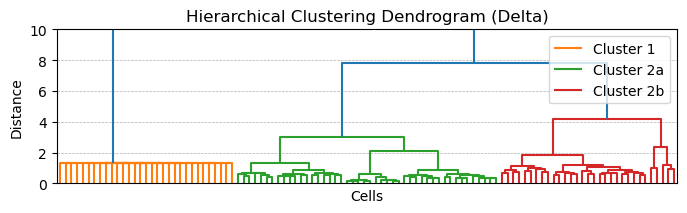

In [89]:
# Function to plot the dendrogram
def plot_dendrogram(series, color_threshold=6, max_distance=10):
    # Compute the distance matrix using DTW
    distance_matrix = cdist_dtw(series)
    
    # Replace non-finite values with a large finite value
    distance_matrix[~np.isfinite(distance_matrix)] = np.max(distance_matrix[np.isfinite(distance_matrix)])
    
    # Perform hierarchical clustering
    Z = linkage(distance_matrix, method='ward')
    
    # Plot the dendrogram
    plt.figure(figsize=(8, 2))
    dendrogram(Z, no_labels=True, color_threshold=color_threshold)
    plt.title('Hierarchical Clustering Dendrogram (Delta)')
    plt.xlabel('Cells')
    plt.ylabel('Distance')
    plt.ylim(0, max_distance)
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

    # Add legend
    plt.legend(['Cluster 1', 'Cluster 2a', 'Cluster 2b'], loc='upper right')
    plt.show()
    
    return Z

# Create a dictionary mapping cell identifiers to their corresponding columns in the array
delta_identifier_map = {idx: cell for idx, cell in enumerate(df_wide_delta_copy.columns)}

# Sample usage:

# Plot dendrogram
Z_delta = plot_dendrogram(delta_series, color_threshold=6, max_distance=10)




#### Dendrogram Observations
- Two highly distinct clusters with a cut at 10.
    - Cluster to the left (yellow) is highly distinct from all clusters to the right (green)
- Three distinct clusters with a cut at 6
- The next cut would result in a subcluster that is much smaller than all others, so it is not performed.

In [92]:
def plot_cluster_centroids_dtw(series, cluster_labels=None, custom_labels=None, identifier_map=None, time_index=None, model_name="Hierarchical", Z=None, color_threshold=None):
    # If hierarchical, generate cluster labels from Z and color_threshold
    if model_name == "Hierarchical" and Z is not None:
        if color_threshold is None:
            raise ValueError("color_threshold must be provided for hierarchical clustering.")
        if cluster_labels is None:
            cluster_labels = fcluster(Z, color_threshold, criterion='distance')

        # Extract the colors from the dendrogram
        dendro = dendrogram(Z, no_labels=True, color_threshold=color_threshold, no_plot=True)
        cluster_to_color = {i + 1: dendro['leaves_color_list'][dendro['leaves'].index(next(idx for idx in range(len(cluster_labels)) if cluster_labels[idx] == i + 1))]
                            for i in range(len(np.unique(cluster_labels)))}
    else:
        if cluster_labels is None:
            raise ValueError("Cluster labels must be provided for non-hierarchical models.")
        # Use a default colormap for non-hierarchical clustering
        cluster_to_color = {i: plt.get_cmap('tab10')(i % 10) for i in np.unique(cluster_labels)}

    # Assign default labels if custom_labels is not provided
    if custom_labels is None:
        custom_labels = {i: f"Cluster {i}" for i in np.unique(cluster_labels)}

    # List the cell identifiers in each cluster
    clusters = {i: [] for i in np.unique(cluster_labels)}
    for idx, cluster in enumerate(cluster_labels):
        clusters[cluster].append(identifier_map[idx])
    
    # Create a DataFrame to store the cluster information
    max_len = max(len(cells) for cells in clusters.values())
    cluster_df = pd.DataFrame(index=range(max_len))
    
    for cluster, cells in clusters.items():
        cluster_df[f'{custom_labels[cluster]}: {len(cells)} cells'] = pd.Series(cells)
    
    # Plot the cluster centroids (barycenters)
    unique_clusters = np.unique(cluster_labels)
    
    for idx, cluster_id in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_series = series[cluster_indices]
        
        # Find the valid range for the cluster
        valid_start = 0
        valid_end = series.shape[1] - 1
        
        for ts in cluster_series:
            first_valid_index = np.where(~np.isnan(ts))[0][0]
            last_valid_index = np.where(~np.isnan(ts))[0][-1]
            valid_start = max(valid_start, first_valid_index)
            valid_end = min(valid_end, last_valid_index)
        
        # Truncate series within the valid range
        truncated_series = [ts[valid_start:valid_end + 1] for ts in cluster_series]
        time_range = time_index[valid_start:valid_end + 1]
        
        # Remove series with all NaNs in the truncated range
        valid_series = [ts for ts in truncated_series if not np.isnan(ts).all()]
        
        # Get the color for the cluster
        color = cluster_to_color[cluster_id]
        
        if len(valid_series) > 0:
            # Compute DTW barycenter
            barycenter = dtw_barycenter_averaging(valid_series)
            
            plt.figure(figsize=(8, 1))
            for s in cluster_series:
                plt.plot(time_index, s, alpha=0.3, color=color)
            plt.plot(time_range, barycenter, color='black', linewidth=2)
            
            # Title handling
            if idx == 0:
                plt.title(f"{model_name} with DTW metric, {custom_labels[cluster_id]} ({len(cluster_series)} cells)")
            else:
                plt.title(f"{custom_labels[cluster_id]} ({len(cluster_series)} cells)")
            
            # Axis handling
            plt.ylim(0.4, 0.8)
            if idx == len(unique_clusters) - 1:
                plt.xlabel("Time (minutes)")
                plt.xticks()  # Auto-label x-axis ticks on the last subplot
            else:
                plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)  # Show ticks but hide labels on other subplots
            plt.ylabel("Delta")
            
            # Create custom legend handles
            cell_line = mlines.Line2D([], [], color=color, label="Cells")
            centroid_line = mlines.Line2D([], [], color='black', linewidth=2, label="DTW Centroid")
            plt.legend(handles=[cell_line, centroid_line], loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
            
            plt.show()

    return cluster_df


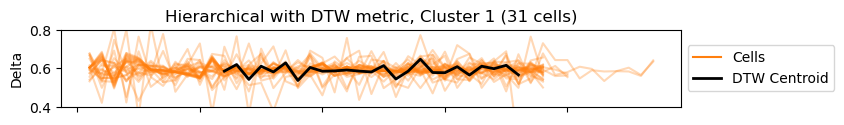

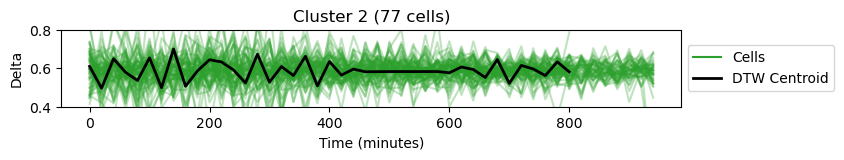

,Cluster 1: 31 cells,Cluster 2: 77 cells
0,Mov. 1 - Cell 10,Mov. 2 - 15 (purple)
1,Mov. 1 - Cell 10.1,Mov. 2 - 15 (white)
2,Mov. 1 - Cell 11,Mov. 2 - Cell 1
3,Mov. 1 - Cell 11.1,Mov. 2 - Cell 11
4,Mov. 1 - Cell 12,Mov. 2 - Cell 12


In [24]:
# Plot clusters with DTW centroids and get cluster identifiers
Hierarch_2cluster_df = plot_cluster_centroids_dtw(
    delta_series,
    Z=Z_delta,  # Specify Z here for hierarchical clustering
    color_threshold=10,
    identifier_map=delta_identifier_map,
    time_index=np.arange(delta_series.shape[1]) * 20,
    model_name="Hierarchical"
)

# Display the DataFrame with cell identifiers
display(Hierarch_2cluster_df.head())


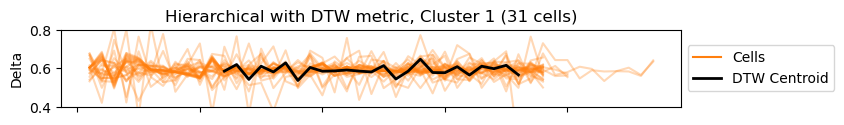

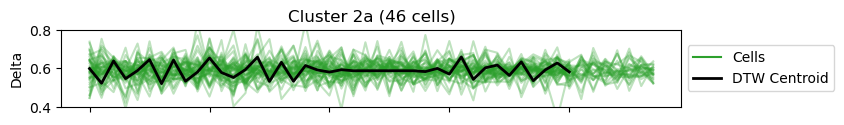

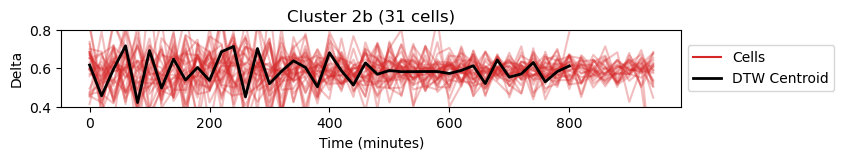

In [25]:
# Pass custom labels for report 
custom_labels = {1: "Cluster 1", 2: "Cluster 2a", 3: "Cluster 2b"}
Hierarch_3cluster_df = plot_cluster_centroids_dtw(
    delta_series,
    Z=Z_delta,  
    color_threshold=6,
    identifier_map=delta_identifier_map,
    time_index=np.arange(delta_series.shape[1]) * 20,
    model_name="Hierarchical",
    custom_labels=custom_labels
)


### Summary: Hierarchical Clustering with DTW Metric

#### Dendrogram Results:
- **Two highly distinct clusters with a cut at 10**
    - Cluster to the left on the dendrogram (yellow) is highly distinct from all clusters to the right (green)
- **Three distinct clusters with a cut at 6**
    - The main cluster (yellow on the dendrogram), with the green cluster subdivided into two.
- **Six somewhat distinct clusters with a cut at 2.5**
    - Ignored since one of the new clusters would be tiny

#### Cluster DataFrames:
- The DataFrames `Hierarch_2cluster_df` with 2 clusters, and `Hierarch_3cluster_df` with three, contain the cell identifiers for each cluster.
- Columns are labeled with the cluster number and the number of cells in each cluster.
- Rows contain the unique identifiers (Movie and Cell).

#### Notes on the DTW Centroid:
- DTW centroids require no NaN values in the time series.
- To address this, we truncate the series to a valid range without NaNs before computing the centroid.
- The DTW centroid is plotted within the truncated time range, while the entire series is shown in the background for context.


### 5. Gaussian Mixture Models (GMMs) with DTW Metric
- Strengths: Flexible in modeling clusters of different shapes and sizes, but assumes Gaussian distributions
- Best For: Time series that can be approximated by Gaussian mixtures
- https://scikit-learn.org/stable/modules/mixture.html#gaussian-mixture. 


Clusters: 1 - BIC: -14416.475131066818, AIC: -30493.169706449393
Clusters: 2 - BIC: -26154.998850484895, AIC: -58311.070132477165
Clusters: 3 - BIC: -18383.48577796806, AIC: -66618.93376657003
Clusters: 4 - BIC: 7265.201958658494, AIC: -57049.62273655318
Clusters: 5 - BIC: 34699.136957105206, AIC: -45695.06444471616
Clusters: 6 - BIC: 53692.23627581156, AIC: -42781.34183261951
Clusters: 7 - BIC: 79271.21647326543, AIC: -33281.738341775344
Clusters: 8 - BIC: 108742.61561711639, AIC: -19889.715904534067
Clusters: 9 - BIC: 133555.72322430852, AIC: -11155.985003951631
Clusters: 10 - BIC: 159056.56821455562, AIC: -1734.5167203142046


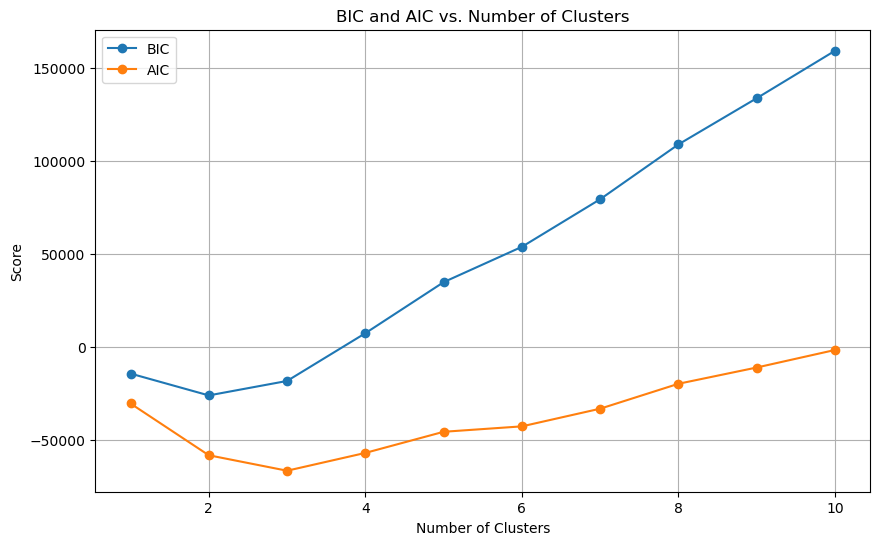

Time taken: 1.0967 seconds


In [28]:
start_time = time.time()  # Start timing

# Function to calculate BIC and AIC for GMM with DTW metric
def evaluate_gmm_dtw(series, max_clusters=10):
    # Compute the distance matrix using DTW
    distance_matrix = cdist_dtw(series)
    
    # Replace non-finite values with a large finite value
    distance_matrix[~np.isfinite(distance_matrix)] = np.max(distance_matrix[np.isfinite(distance_matrix)])
    
    bic_scores = []
    aic_scores = []
    
    for n_clusters in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
        gmm.fit(distance_matrix)
        
        bic_scores.append(gmm.bic(distance_matrix))
        aic_scores.append(gmm.aic(distance_matrix))
        
        print(f"Clusters: {n_clusters} - BIC: {bic_scores[-1]}, AIC: {aic_scores[-1]}")
    
    return bic_scores, aic_scores

# Evaluate the GMM model for different numbers of clusters
max_clusters = 10  # Adjust this value based on the range of clusters you want to test
bic_scores, aic_scores = evaluate_gmm_dtw(delta_series, max_clusters=max_clusters)

# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), bic_scores, label='BIC', marker='o')
plt.plot(range(1, max_clusters + 1), aic_scores, label='AIC', marker='o')
plt.title("BIC and AIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Time taken: {elapsed_time:.4f} seconds")

Time taken: 0.7681 seconds


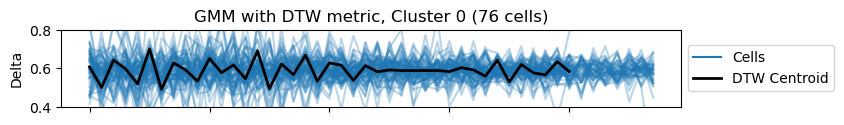

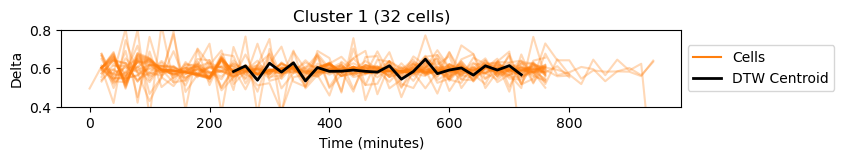

,Cluster 0: 76 cells,Cluster 1: 32 cells
0,Mov. 2 - 15 (purple),Mov. 1 - Cell 10
1,Mov. 2 - 15 (white),Mov. 1 - Cell 10.1
2,Mov. 2 - Cell 1,Mov. 1 - Cell 11
3,Mov. 2 - Cell 11,Mov. 1 - Cell 11.1
4,Mov. 2 - Cell 12,Mov. 1 - Cell 12


In [29]:
# Start timing
start_time = time.time()

# Function to perform GMM classification with DTW
def gmm_dtw_classification(series, n_clusters):
    # Compute the distance matrix using DTW
    distance_matrix = cdist_dtw(series)
    
    # Replace non-finite values with a large finite value
    distance_matrix[~np.isfinite(distance_matrix)] = np.max(distance_matrix[np.isfinite(distance_matrix)])
    
    # Fit GMM using the precomputed DTW distance matrix
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmm.fit(distance_matrix)
    
    # Predict cluster labels
    cluster_labels = gmm.predict(distance_matrix)
    
    return cluster_labels

# Number of clusters to find
n_clusters = 2  # Adjust as needed

# Perform GMM classification
cluster_labels = gmm_dtw_classification(delta_series, n_clusters)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.4f} seconds")

# Plot the GMM clusters using the previously defined function
GMM_2cluster_df = plot_cluster_centroids_dtw(
    delta_series,
    cluster_labels=cluster_labels,  # Pass the GMM cluster labels
    identifier_map=delta_identifier_map,
    time_index=np.arange(delta_series.shape[1]) * 20,
    model_name="GMM"
)

# Display the DataFrame with cell identifiers
display(GMM_2cluster_df.head())


Time taken: 0.8007 seconds


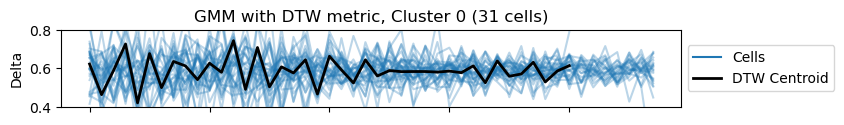

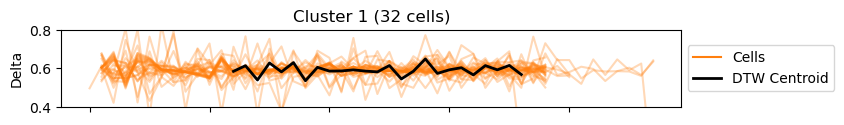

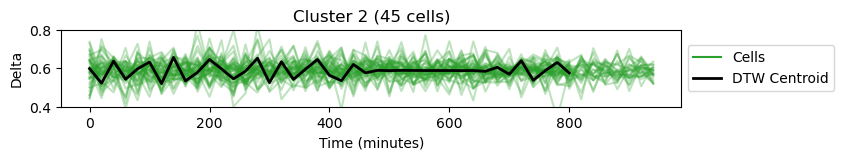

,Cluster 0: 31 cells,Cluster 1: 32 cells,Cluster 2: 45 cells
0,Mov. 2 - Cell 1,Mov. 1 - Cell 10,Mov. 2 - 15 (purple)
1,Mov. 2 - Cell 11,Mov. 1 - Cell 10.1,Mov. 2 - 15 (white)
2,Mov. 2 - Cell 16,Mov. 1 - Cell 11,Mov. 2 - Cell 12
3,Mov. 2 - Cell 2,Mov. 1 - Cell 11.1,Mov. 2 - Cell 13
4,Mov. 2 - Cell 22,Mov. 1 - Cell 12,Mov. 2 - Cell 14
5,Mov. 2 - Cell 23,Mov. 1 - Cell 12.1,Mov. 2 - Cell 18
6,Mov. 2 - Cell 34,Mov. 1 - Cell 13.1,Mov. 2 - Cell 4
7,Mov. 2 - Cell 36,Mov. 1 - Cell 14.1,Mov. 2 - Cell C1
8,Mov. 3 - Cell 14,Mov. 1 - Cell 15,Mov. 2 - Cell C2
9,Mov. 3 - Cell 21,Mov. 1 - Cell 15.1,Mov. 2 - Cell C3


In [30]:
# Start timing
start_time = time.time()

# Number of clusters to find
n_clusters = 3  # Adjust as needed

# Perform GMM classification
cluster_labels = gmm_dtw_classification(delta_series, n_clusters)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.4f} seconds")

# Plot the GMM clusters using the previously defined function
GMM_3cluster_df = plot_cluster_centroids_dtw(
    delta_series,
    cluster_labels=cluster_labels,  # Pass the GMM cluster labels
    identifier_map=delta_identifier_map,
    time_index=np.arange(delta_series.shape[1]) * 20,
    model_name="GMM"
)

# Display the DataFrame with cell identifiers
display(GMM_3cluster_df.head(50))

### Summary: GMM Clustering with DTW Metric

#### Model Results:
- **BIC reached its minimum with 2 clusters**, indicating this as the optimal number.
- **AIC reached its minimum with 3 clusters**, suggesting a possible third cluster could add detail, although the evidence for this is weaker.

#### Cluster DataFrames:
- **Two Clusters:**
  - `GMM_2cluster_df` shows two distinct clusters with high consistency to the hierarchical results.
- **Three Clusters:**
  - `GMM_3cluster_df` divides the larger cluster from the two-cluster result into two subclusters.

#### Key Takeaway:
- The GMM clustering aligns closely with the hierarchical results.

### 6. Density-Based Spatial Clustering of Applications with Noise (DBSCAN) with DTW Metric
- Strengths: Identifies clusters of varying shapes and sizes, including non-globular clusters, and can handle noise.
- Best For: Non-globular clusters and time series with varying density.
- https://scikit-learn.org/stable/modules/clustering.html#dbscan 


In [33]:
# Function to perform DBSCAN classification with DTW
def dbscan_dtw_classification(series, eps, min_samples):
    # Compute the distance matrix using DTW
    distance_matrix = cdist_dtw(series)
    
    # Replace non-finite values with a large finite value
    distance_matrix[~np.isfinite(distance_matrix)] = np.max(distance_matrix[np.isfinite(distance_matrix)])
    
    # Fit DBSCAN using the precomputed DTW distance matrix
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
    db.fit(distance_matrix)
    
    # Predict cluster labels
    cluster_labels = db.labels_
    
    return cluster_labels

# Function to evaluate DBSCAN for different eps values
def evaluate_dbscan(series, eps_values, min_samples):
    for eps in eps_values:
        print(f"Evaluating DBSCAN with eps={eps}")
        start_time = time.time()
        cluster_labels = dbscan_dtw_classification(series, eps, min_samples)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken: {elapsed_time:.4f} seconds")
        
        # Count the number of clusters and size of each
        unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
        cluster_info = {cluster: count for cluster, count in zip(unique_clusters, counts)}
        
        print(f"Number of clusters found: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
        for cluster, size in cluster_info.items():
            if cluster != -1:
                print(f"Cluster {cluster + 1}: {size} cells")
            else:
                print(f"Noise: {size} cells")
        print("\n")  # Separate outputs for different eps values


In [34]:
# # Evaluate DBSCAN with a range of epsilon values
# # Uncomment below to run DBSCAN
# eps_values = np.arange(0.1, 1.1, 0.1)
# min_samples = 10  # Set min_samples
# evaluate_dbscan(delta_series, eps_values, min_samples)

#### Summary of DBSCAN Results:

**Clustering Behavior**: Across the range of eps values (0.1 to 1.0), and for min_samples from 5 to 30, DBSCAN consistently found only a single cluster, with varying levels of noise. Noise decreased as eps increased, indicating that higher eps values absorbed more data points into the single cluster. From eps 0.5 to 0.9, the Noise has the same number of cells as the most distinctive cluster in Hierarchical and GMM classification, suggesting that it may be finding that same cluster but labelling it as noise?

**Optimal Cluster Size**: The minimal noise occurred at eps = 1.0, where all 108 cells were clustered together.

**Implication**: The results suggest that the dataset's structure may not be well-suited for DBSCAN.



### 7. Overlap Matrix
- Create a matrix with the number of cells in the pair-wise intersections of clusters.
- Compare the extent of overlap between clusters identified by different clustering algorithms.

In [37]:
# Rename the dfs:
G2 = GMM_2cluster_df
G3 = GMM_3cluster_df
H2 = Hierarch_2cluster_df
H3 = Hierarch_3cluster_df


# Function to create the overlap matrix between clusters
def create_overlap_matrix(cluster_dfs, cluster_labels):
    overlap_matrix = pd.DataFrame(index=cluster_labels, columns=cluster_labels, data=0)
    
    for i in range(len(cluster_labels)):
        for j in range(len(cluster_labels)):
            # Count the overlap between columns:
            cluster_i_cells = cluster_dfs[cluster_labels[i]].dropna().unique()
            cluster_j_cells = cluster_dfs[cluster_labels[j]].dropna().unique()
            overlap = len(set(cluster_i_cells) & set(cluster_j_cells))
            overlap_matrix.iloc[i, j] = overlap
    
    # Add the size of each cluster to the code in the overlap matrix
    for label in cluster_labels:
        cluster_size = cluster_dfs[label].notna().sum()
        overlap_matrix.rename(index={label: f"{label} ({cluster_size})"}, inplace=True)
        overlap_matrix.rename(columns={label: f"{label} ({cluster_size})"}, inplace=True)
    
    return overlap_matrix

# Combine all cluster dataframes into one with correct headers
combined_clusters = pd.concat([G2, G3, H2, H3], axis=1)
combined_clusters.columns = ['G2C1', 'G2C2', 'G3C1', 'G3C2', 'G3C3', 'H2C1', 'H2C2', 'H3C1', 'H3C2', 'H3C3']

# Ensure all values are strings, drop NaNs
combined_clusters = combined_clusters.map(lambda x: x if isinstance(x, str) else np.nan)

# Define cluster labels
cluster_labels = combined_clusters.columns

# Create the overlap matrix
overlap_matrix = create_overlap_matrix(combined_clusters, cluster_labels)

# Display the overlap matrix
display(overlap_matrix)


,G2C1 (76),G2C2 (32),G3C1 (31),G3C2 (32),G3C3 (45),H2C1 (31),H2C2 (77),H3C1 (31),H3C2 (46),H3C3 (31)
G2C1 (76),76,0,31,0,45,0,76,0,46,30
G2C2 (32),0,32,0,32,0,31,1,31,0,1
G3C1 (31),31,0,31,0,0,0,31,0,1,30
G3C2 (32),0,32,0,32,0,31,1,31,0,1
G3C3 (45),45,0,0,0,45,0,45,0,45,0
H2C1 (31),0,31,0,31,0,31,0,31,0,0
H2C2 (77),76,1,31,1,45,0,77,0,46,31
H3C1 (31),0,31,0,31,0,31,0,31,0,0
H3C2 (46),46,0,1,0,45,0,46,0,46,0
H3C3 (31),30,1,30,1,0,0,31,0,0,31


**Summary:**

We performed a detailed comparison between clusters identified by two different unsupervised classification algorithms: Hierarchical Clustering and Gaussian Mixture Models (GMM), each with both 2-cluster and 3-cluster solutions. The primary objective was to determine the degree of overlap between clusters identified by these methods, using a relative frequency matrix to visualize the intersection of cell identities across different cluster solutions.

Key Steps:
Clustering Algorithms: We first applied Hierarchical Clustering and GMM to the dataset using a Dynamic Time Warping (DTW) metric. Both algorithms were tested with 2-cluster and 3-cluster configurations.

Cluster DataFrames: For each clustering solution, we created DataFrames containing the cells assigned to each cluster. These DataFrames were then merged into a single DataFrame, with consistent naming conventions to track the source of each cluster (e.g., G2C1 for GMM with 2 clusters, Cluster 1).

Overlap Matrix: We constructed a 10x10 overlap matrix representing the 10 clusters across the different models. Each cell in this matrix shows the number of overlapping cells between any two clusters. The diagonal represents self-comparisons and shows 100% overlap, as expected.

Summary of Results:
High Consistency Between Models: The matrix confirmed that the clusters identified by Hierarchical Clustering and GMM are highly consistent. Specifically, the 2-cluster solutions from both methods show near-identical overlap, with 31 of 32 cells in one cluster and 76 of 77 in the other. **Furthermore, the smaller primary cluster is nearly identical to Movie 1.**
Sub-Clustering: When examining the 3-cluster solutions, the larger of the two initial clusters was subdivided into two smaller clusters with a high degree of overlap between the two models: 46 of 47 cells in one sub-cluster and 29 of 31 in another. 
This analysis underscores the robustness and consistency of the clustering across different algorithms, particularly in identifying two primary clusters, with one of those clusters being further subdivided similarly by both methods.

**Notes:**

- When we truncate all time series to have same length as the smallest movie:
    - Clusters remain consistent across many nan_thresholds: nan_threshold = 0.01 (54 cells removed including all of Movie 1), 0.05 (30 cells removed), 0.1 (25), 0.25 (10)

- When we do not truncate:
    - Clusters remain consistent, but we must remove cells that have 25% or more NaNs (nan_threshold = 0.25), 23 cells removed.

- The small cluster is primarily from Movie 1. Movie 1 cells do not appear in other clusters for:
nan_threshold = 0.01 (54 cells removed including all of Movie 1), 0.05 (30 cells removed), 0.1 (25), 0.25 (10)

**Current parameters:** 
- nan_threshold = 0.25
- truncate_series = False

As we reduce nan_threshold, DBSCAN starts to find similar numbers but calls the small distinct cluster "noise"